# Setup environment and load data

In [16]:
# import necessary libraries, ntlk,spacy, and gensim were pre-installed
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import spacy
import random
import gensim
from collections import defaultdict, Counter
import re

In [2]:
os.getcwd()

'C:\\Users\\Shru\\Documents\\Springboard\\Capstone 3'

In [3]:
os.listdir()

['.ipynb_checkpoints',
 'Capstone_3_playground.ipynb',
 'data',
 'images',
 'Medical Texts - DeepLearningModels.ipynb',
 'Medical Texts - EDA.ipynb',
 'Medical Texts - Modeling.ipynb',
 'medical_transcriptions',
 'medical_transcriptions.zip',
 'ocular_disease_dataset',
 'ocular_disease_dataset.zip',
 'ocular_disease_load.ipynb',
 'PyTorch playground.ipynb']

In [4]:
data = pd.read_csv('medical_transcriptions/mtsamples.csv',index_col=0)
print(data.shape)
data.head()

(4999, 5)


,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


# Data Cleaning
This dataset was downloaded from public kaggle datasets. This next section will focus on exploring the data and then setting up the data for modelling. Cleaning steps such as tokenization, lemmatization, removing stopwords and characters, and normalizing the data. The text is stored in the 'transcription' column. This is labeled data and we will be using the column medical_specialty as the labels.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4999 entries, 0 to 4998
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        4999 non-null   object
 1   medical_specialty  4999 non-null   object
 2   sample_name        4999 non-null   object
 3   transcription      4966 non-null   object
 4   keywords           3931 non-null   object
dtypes: object(5)
memory usage: 234.3+ KB


In [6]:
data.iloc[24]

description           Blood in urine - Transitional cell cancer of ...
medical_specialty                                              Urology
sample_name                                        Urology Consut - 1 
transcription                                        CHIEF COMPLAINT:,
keywords                                                           NaN
Name: 24, dtype: object

In [7]:
data[data['keywords'].isna()]['transcription'].sample(3)

4180    HISTORY OF PRESENT ILLNESS: , This is a 91-yea...
2856    REASON FOR VISIT:  ,This is an 83-year-old wom...
2813    CC: ,Paraplegia.,HX:, This 32 y/o RHF had been...
Name: transcription, dtype: object

In [8]:
# drop empty transcription values, drop uncessary columns for our modeling
data = data.drop(data[data['transcription'].isna()].index).reset_index(drop=True)
data = data[['medical_specialty','transcription']]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4966 entries, 0 to 4965
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  4966 non-null   object
 1   transcription      4966 non-null   object
dtypes: object(2)
memory usage: 77.7+ KB


In [9]:
# inspect some text
data.iloc[24]['transcription']

'CHIEF COMPLAINT:,'

This index shows that some of the data may lack general text. How do we deal with kind of data? From looking at other transcription we can see that each text starts with a sort of title, do the texts have more than one title within it? For now this data will be kept in.

In [10]:
# inspect label distributions
print(data['medical_specialty'].value_counts())

# keep a list of lables, may coeme in handy later
med_area = list(data['medical_specialty'].unique())


 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

We have a very imbalanced dataset. We may have to come up with a way to deal with these imbalances later, for now the data will be left as is with 40 classes.

### Text Cleaning
<ul>
    <li>Load spacy with english</li>
    <li>Load nltk tokenizer</li>
    <li>Load stopwords</li>
    <li>Create functions for lemaatizing text, removing stopwords, removed special characters, and normalize text</li>
</ul>

In [11]:
# load spacy
nlp = spacy.load('en_core', parse=True, tag=True, entity=True)

# import nltk tokenizer
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import sent_tokenize

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [12]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def normalize_corpus(corpus, text_lemmatization=True, text_lower_case=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    normalized_corpus = []
    for doc in corpus:
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [13]:
data['cleaned_text'] = normalize_corpus(data['transcription'])
print(data['transcription'][4])
print(data['cleaned_text'][4])

1.  The left ventricular cavity size and wall thickness appear normal.  The wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of 70% to 75%.  There is near-cavity obliteration seen.  There also appears to be increased left ventricular outflow tract gradient at the mid cavity level consistent with hyperdynamic left ventricular systolic function.  There is abnormal left ventricular relaxation pattern seen as well as elevated left atrial pressures seen by Doppler examination.,2.  The left atrium appears mildly dilated.,3.  The right atrium and right ventricle appear normal.,4.  The aortic root appears normal.,5.  The aortic valve appears calcified with mild aortic valve stenosis, calculated aortic valve area is 1.3 cm square with a maximum instantaneous gradient of 34 and a mean gradient of 19 mm.,6.  There is mitral annular calcification extending to leaflets and supportive structures with thickening of mitral valve leaflets with mil

In [14]:
tokenizer = ToktokTokenizer()
data['tokens'] = data['cleaned_text'].apply(tokenizer.tokenize)

# Exploratory Data Analysis

In [17]:
bow = data['tokens'].apply(lambda x: Counter(x))
bow.apply(lambda x: x.most_common(5))

0       [(use, 6), (not, 4), (allergy, 3), (think, 3),...
1       [(history, 6), (pain, 5), (difficulty, 4), (di...
2       [(history, 7), (pound, 7), (drink, 7), (year, ...
3       [(normal, 4), (valve, 4), (leave, 2), (atrial,...
4       [(appear, 9), (valve, 6), (ventricular, 5), (n...
                              ...                        
4961    [(no, 14), (note, 13), (patient, 12), (nasal, ...
4962    [(fever, 6), (day, 5), (ivig, 5), (discharge, ...
4963    [(no, 18), (without, 7), (past, 6), (not, 5), ...
4964    [(no, 7), (asthma, 4), (history, 4), (male, 3)...
4965    [(history, 13), (no, 13), (allergy, 9), (react...
Name: tokens, Length: 4966, dtype: object

In [18]:
from gensim.corpora.dictionary import Dictionary

dictionary = Dictionary(data.tokens)

corpus = data.tokens.apply(lambda x: dictionary.doc2bow(x))

In [19]:
import itertools

total_word_count = defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus):
    total_word_count[word_id]+=word_count

In [20]:
sorted_bow = sorted(total_word_count.items(), key=lambda kv :kv[1], reverse=True)
words = []
word_counts = []
for word_id, word_count in sorted_bow[:20]:
    words.append(dictionary.get(word_id)) 
    word_counts.append(word_count)

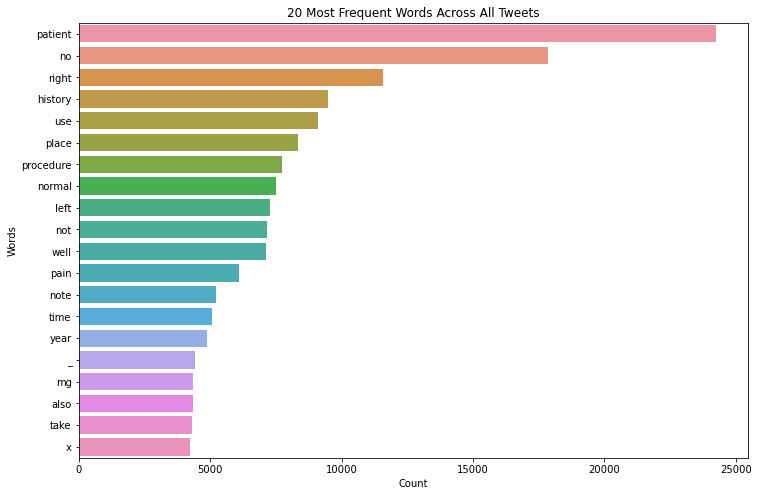

In [21]:
fig = plt.figure(figsize=(12,8))
fig = sns.barplot(x=word_counts, y=words)
fig = plt.xlabel("Count")
fig = plt.ylabel('Words')
fig = plt.title('20 Most Frequent Words Across All Tweets')
plt.show()

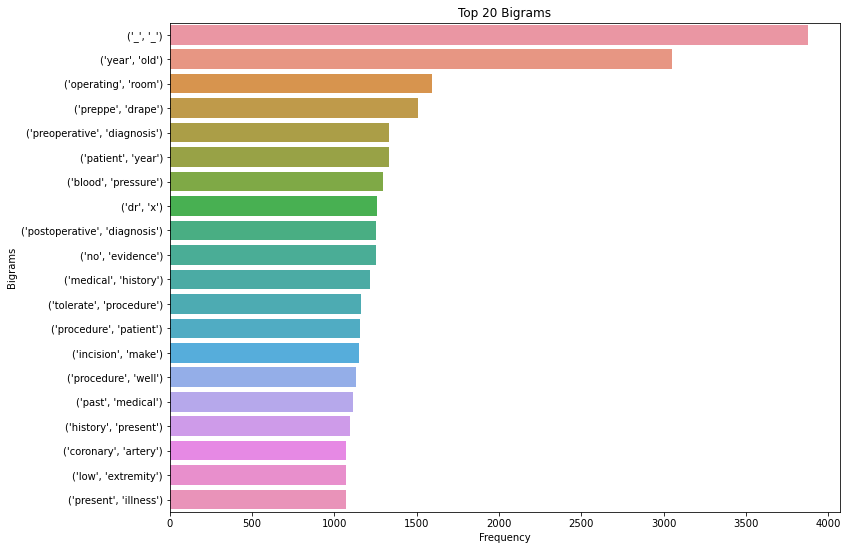

In [22]:
from nltk.util import ngrams


bigrams = data.tokens.apply(lambda x: ngrams(x,2))

bi_grams = bigrams.apply(lambda x: list(x))

top_20_bigrams = Counter(itertools.chain.from_iterable(bi_grams)).most_common(20)

top_bigram = pd.DataFrame(top_20_bigrams, columns=['bigram', 'frequency'])
top_bigram.set_index('bigram', inplace=True)
_ = plt.figure(figsize=(12,9))
_ = sns.barplot(x=top_bigram.frequency, y=top_bigram.index, orient='h')
_ = plt.xlabel('Frequency')
_ = plt.ylabel('Bigrams')
_ = plt.title('Top 20 Bigrams')
plt.show()

In [31]:
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import RegexpTokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# Create a list of tokens for each sentence
tokenizer = RegexpTokenizer(r'\w+')
data["tokens"] = data["transcription"].apply(tokenizer.tokenize)

all_words = [word for tokens in data["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))


2420937 words total, with a vocabulary size of 28581
Max sentence length is 3114


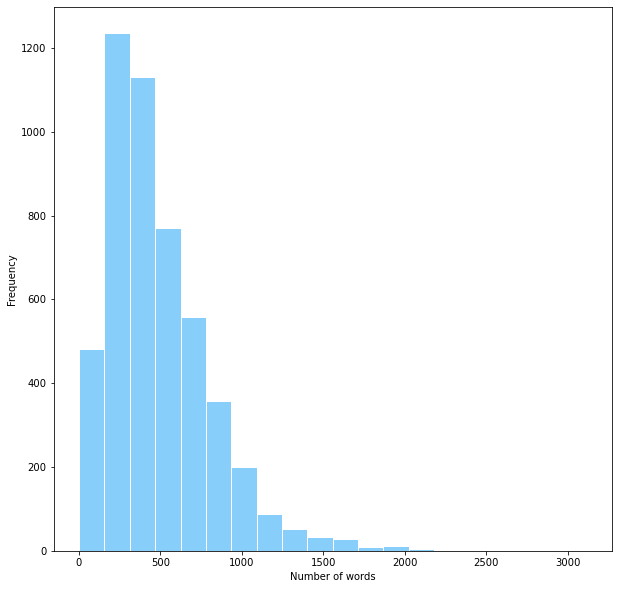

In [54]:
_ = data['tokens'].str.len().hist(edgecolor = 'w', bins = 20, color='lightskyblue', grid=False, figsize=(10,10))
_ = plt.xlabel('Number of words')
_ = plt.ylabel('Frequency')
plt.show()

In [52]:
df = data.copy()
tokenizer = ToktokTokenizer()
df['clean'] = normalize_corpus(data['transcription'], special_char_removal=False)
df['tokens'] = df['clean'].apply(tokenizer.tokenize)
all_words = [word for tokens in df["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

1957566 words total, with a vocabulary size of 23069
Max sentence length is 2347


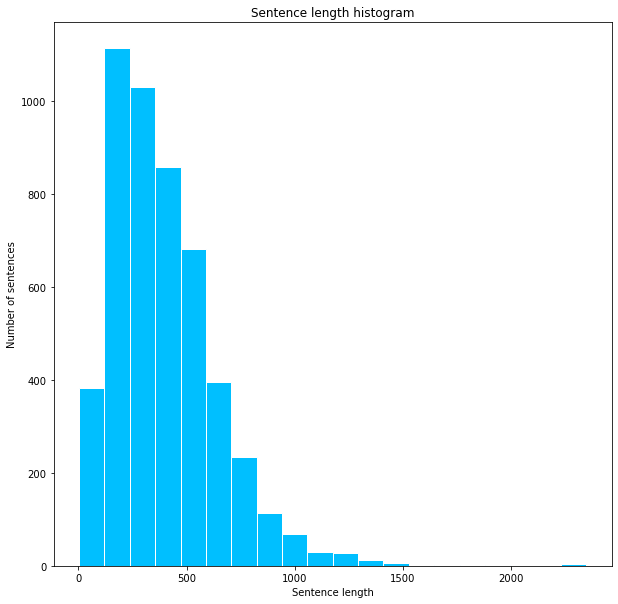

In [53]:
fig = plt.figure(figsize=(10, 10)) 
_ = plt.title('Sentence length histogram')
_ = plt.xlabel('Sentence length')
_ = plt.ylabel('Number of sentences')
_ = plt.hist(sentence_lengths, edgecolor = 'w', bins = 20, color='deepskyblue')
plt.show()

# Prepare and Preprocess data for Modeling

In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [24]:
def text_prepare(text):

    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(nltk.corpus.stopwords.words('english'))
    
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub('', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    
    return text

def preprocess(df):
    df_temp = df.copy()
    df_temp = df_temp.rename(index=str, columns={'transcription':'text'})
    
    df_temp.loc[:, 'text'] = normalize_corpus(data['transcription'], 
                                              text_lemmatization = False, 
                                              text_lower_case=False, 
                                              special_char_removal=False)
    df_temp.loc[:, 'text'] = [text_prepare(x) for x in df_temp['text'].values]
    
    le = LabelEncoder()
    le.fit(df_temp['medical_specialty'])
    df_temp.loc[:, 'class_label'] = le.transform(df_temp['medical_specialty'])
    
    tokenizer = ToktokTokenizer()
    
    df_temp['tokens'] = df_temp['text'].apply(tokenizer.tokenize)
    
    return df_temp


In [25]:
data = data[['medical_specialty','transcription']]

In [26]:
df_temp = data.copy(deep=True)
df_temp = preprocess(df_temp)

In [27]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4966 entries, 0 to 4965
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  4966 non-null   object
 1   text               4966 non-null   object
 2   class_label        4966 non-null   int32 
 3   tokens             4966 non-null   object
dtypes: int32(1), object(3)
memory usage: 174.6+ KB


#### Split the data into train and test sets and save to disc

In [28]:
os.getcwd()

'C:\\Users\\Shru\\Documents\\Springboard\\Capstone 3'

In [68]:
path = 'C:\\Users\\Shru\\Documents\\Springboard\\Capstone 3/data'
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Successfully created the directory /data 


In [70]:
train, test = train_test_split(df_temp, test_size=0.2, random_state=42)

train.to_csv('/data/trainingset.tsv', sep='\t', index=False)
test.to_csv('/data/testset.tsv', sep='\t', index=False)

In [29]:
df_temp.to_csv('C:\\Users\\Shru\\Documents\\Springboard\\Capstone 3/data/datafull_nolemma.tsv',sep='\t', index=False)